In [42]:
import pandas as pd
import numpy as np
import pyro
import torch
import pyro.distributions as dist
from pyro.contrib.forecast import ForecastingModel, Forecaster
from pyro.ops.tensor_utils import periodic_repeat
import matplotlib.pyplot as plt

In [31]:
data = pd.read_csv('../data/sales_train_evaluation.csv.zip')
cal = pd.read_csv('../data/calendar.csv', index_col=0)
all_sum = data.iloc[:,6:].sum().values

In [35]:
data = torch.from_numpy(all_sum).type(torch.get_default_dtype()).unsqueeze(-1).log()

In [26]:
dom = pd.get_dummies(pd.to_datetime(cal.index).day).values
day_of_month = torch.from_numpy(dom).type(torch.get_default_dtype())

In [43]:
class Model(ForecastingModel):
    def model(self, zero_data, covariates):
        assert zero_data.size(-1) == 1  # univariate
        duration = zero_data.size(-2)
        time, feature = covariates[..., 0], covariates[..., 1:]

        bias = pyro.sample("bias", dist.Normal(0, 10))
        # construct a linear trend; we know that the sales are increasing
        # through years, so a positive-support prior should be used here
        trend_coef = pyro.sample("trend", dist.LogNormal(-2, 1))
        trend = trend_coef * time
        # set prior of weights of the remaining covariates
        weight = pyro.sample("weight",
                             dist.Normal(0, 1).expand([feature.size(-1)]).to_event(1))
        regressor = (weight * feature).sum(-1)
        
        # encode the additive monthly seasonality
        with pyro.plate("month",28,dim=-1):
            seasonal = pyro.sample("seasonal_1", dist.Normal(0, 7))
        seasonal = periodic_repeat(seasonal, duration, dim=-1)


        # make prediction
        prediction = bias + trend  + seasonal + regressor
        prediction = prediction.unsqueeze(-1)

        # Now, we will use heavy tail noise because the data has some outliers
        # (such as Christmas day)
        dof = pyro.sample("dof", dist.Uniform(1, 10))
        noise_scale = pyro.sample("noise_scale", dist.LogNormal(-2, 1))
        noise_dist = dist.StudentT(dof.unsqueeze(-1), 0, noise_scale.unsqueeze(-1))
        self.predict(noise_dist, prediction)

In [37]:
T0 = 0
T2 = data.size(-2) + 28
time = torch.arange(T0, float(T2), device="cpu") / 365
covariates = torch.cat([
    time.unsqueeze(-1),
    day_of_month,
], dim=-1)

In [38]:
forecaster_options = {
    "learning_rate": 0.1,
    "learning_rate_decay": 0.1,
    "clip_norm": 10,
    "num_steps": 1001,
    "log_every": 100,
}

In [47]:
pyro.set_rng_seed(127)
forecaster = Forecaster(Model(), data, covariates[:-28], **forecaster_options)
samples = forecaster(data, covariates, num_samples=2000).exp().squeeze(-1).cpu()
pred = samples.mean(0)

INFO 	 step    0 loss = -0.706285
INFO 	 step  100 loss = -0.615079
INFO 	 step  200 loss = -0.6652
INFO 	 step  300 loss = -0.644186
INFO 	 step  400 loss = -0.681098
INFO 	 step  500 loss = -0.674862
INFO 	 step  600 loss = -0.691537
INFO 	 step  700 loss = -0.67353
INFO 	 step  800 loss = -0.68274
INFO 	 step  900 loss = -0.704619
INFO 	 step 1000 loss = -0.698189


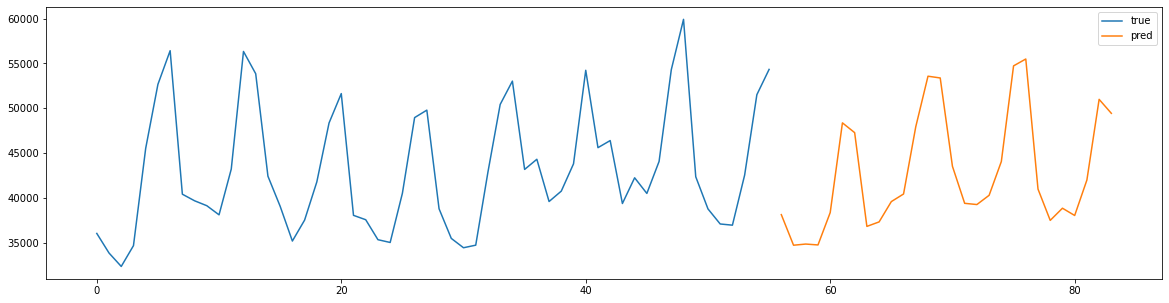

In [52]:
true = torch.from_numpy(all_sum).type(torch.get_default_dtype()).unsqueeze(-1)
plt.figure(figsize=(20,5))
plt.plot(np.arange(0,56),true[-56:],label='true')
plt.plot(np.arange(56,56+28),pred,label='pred')
plt.legend()
plt.show()

In [62]:
quantiles = [0.005, 0.025, 0.165, 0.25, 0.5, 0.75, 0.835, 0.975, 0.995]
q_pred = np.quantile(samples,quantiles,axis=0)

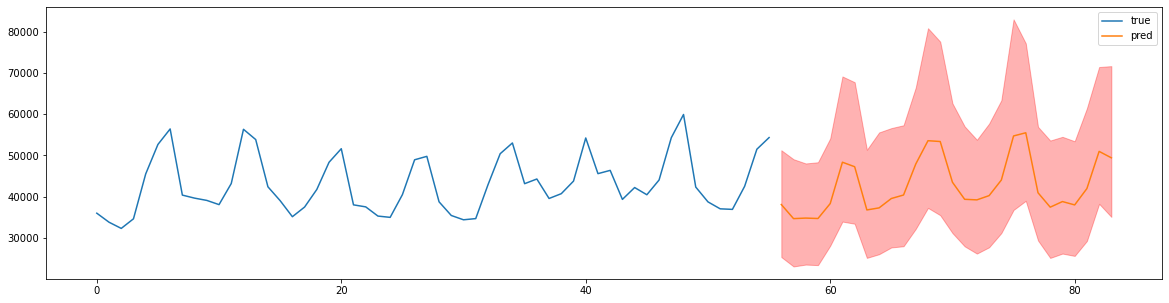

In [63]:
plt.figure(figsize=(20,5))
plt.fill_between(np.arange(56,56+28), q_pred[0], q_pred[-1], color="red", alpha=0.3)
plt.plot(np.arange(56,56+28),pred,label='pred')
plt.plot(np.arange(0,56),true[-56:],label='true')
plt.legend()
plt.show()